In [ ]:
!pip install detoxify

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATASET_PATH='balanced_gender_only.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
from detoxify import Detoxify
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report

# ==========================================
# 1) UPLOAD DATASET
# ==========================================

DATASET_TYPE = "gender"
IDENTITY_COLUMNS= {
    "gender": ["male", "female", "transgender", "other_gender"],
    "race": ["asian", "black", "latino", "white", "other_race_or_ethnicity"]
}
print(f"Loading dataset: {DATASET_PATH}")
df = pd.read_csv(DATASET_PATH)
checkpoint_dir= '/content/drive/My Drive/detoxify_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
# Initializing the model
model= Detoxify("original")
predictions= []
toxicity_scores= []

for idx, comment in enumerate(df['comment_text'].values):
    try:
        result = model.predict(comment)
        toxicity_scores.append(result['toxicity'])
        predictions.append(1 if result['toxicity'] > 0.5 else 0)
    except:
        predictions.append(0)
        toxicity_scores.append(0)

    if (idx + 1) % 1000 == 0: #saving for backup
        df.iloc[:idx+1].to_csv(f'{checkpoint_dir}/checkpoint_{idx+1}.csv', index=False)
        print(f"Processed {idx + 1} comments...")

df['detoxify_toxicity_score']=toxicity_scores
df['detoxify_prediction']=predictions
df['human_label']=(df['target'] >= 0.5).astype(int)
print(f"\nTotal comments processed: {len(df)}\n")
print(f"OVERALL PERFORMANCE - {DATASET_TYPE.upper()} DATASET")

# ==========================================
# 3) OVERALL METRICS
# ==========================================

f1_overall= f1_score(df['human_label'], df['detoxify_prediction'])
precision_overall= precision_score(df['human_label'], df['detoxify_prediction'])
recall_overall= recall_score(df['human_label'], df['detoxify_prediction'])
accuracy_overall=accuracy_score(df['human_label'], df['detoxify_prediction'])

# false positive rate overall
non_toxic_overall = df[df['human_label'] == 0]
fpr_overall = (non_toxic_overall['detoxify_prediction'] == 1).sum() / len(non_toxic_overall) if len(non_toxic_overall) > 0 else 0

print(f"""
F1 Score:  {f1_overall:.4f}
Precision: {precision_overall:.4f}
Recall:    {recall_overall:.4f}
Accuracy:  {accuracy_overall:.4f}
FPR:       {fpr_overall:.4f}
Classification Report:
{classification_report(df['human_label'], df['detoxify_prediction'], target_names=['Non-Toxic', 'Toxic'])}
""")

# ==========================================
# 4) IDENTITY-BASED METRICS
# ==========================================

print(f"IDENTITY-BASED ANALYSIS - {DATASET_TYPE.upper()}")
identity_columns = IDENTITY_COLUMNS[DATASET_TYPE]
bias_results=[]
for identity in identity_columns:
    identity_mask=df[identity] > 0
    if identity_mask.sum() > 0:
        identity_subset=df[identity_mask]

        # Standard metrics
        f1 = f1_score(identity_subset['human_label'], identity_subset['detoxify_prediction'], zero_division=0)
        precision = precision_score(identity_subset['human_label'], identity_subset['detoxify_prediction'], zero_division=0)
        recall = recall_score(identity_subset['human_label'], identity_subset['detoxify_prediction'], zero_division=0)
        accuracy = accuracy_score(identity_subset['human_label'], identity_subset['detoxify_prediction'])
        # False positive rate for this identity
        non_toxic_identity = identity_subset[identity_subset['human_label'] == 0]
        if len(non_toxic_identity) > 0:
            false_positive_rate = (non_toxic_identity['detoxify_prediction'] == 1).sum() / len(non_toxic_identity)
        else:
            false_positive_rate = 0
        bias_results.append({
            'Identity': identity,
            'Count': identity_mask.sum(),
            'F1': f1,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'False_Positive_Rate': false_positive_rate
        })

        print(f"""
{identity.upper()}
  Comments: {identity_mask.sum()}
  F1 Score: {f1:.4f}
  Precision: {precision:.4f}
  Recall: {recall:.4f}
  Accuracy: {accuracy:.4f}
  False Positive Rate: {false_positive_rate:.4f}""")

bias_df= pd.DataFrame(bias_results)

# ==========================================
# 5) FALSE POSITIVES
# ==========================================
print("FALSE POSITIVES")
has_identity=df[identity_columns].sum(axis=1) > 0
false_positives=df[(df['human_label'] == 0) & (df['detoxify_prediction'] == 1) & has_identity]

print(f"\nTotal false positives on {DATASET_TYPE} identity comments: {len(false_positives)}")
print(f"Out of {has_identity.sum()} total identity-related comments")
print(f"False positive rate on identity comments: {len(false_positives)/has_identity.sum() * 100:.2f}%")

print(f"\nTop 5 Examples of False Positives:")
for idx, (_, row) in enumerate(false_positives.head(5).iterrows()):
    print(f"\n{idx+1}. Score: {row['detoxify_toxicity_score']:.4f} | Pred: Toxic | Human: Not Toxic")
    print(f"   Comment: {row['comment_text'][:120]}...")
    mentioned= [id_col for id_col in identity_columns if row[id_col] > 0]
    if mentioned:
        print(f"   {DATASET_TYPE.capitalize()} identities mentioned: {', '.join(mentioned)}")

# ==========================================
# 6) SAVE CSV RESULTS
# ==========================================
output_prefix= f"detoxify_{DATASET_TYPE}"
bias_df.to_csv(f'{output_prefix}_metrics_by_identity.csv', index=False)
false_positives.to_csv(f'{output_prefix}_false_positives_detailed.csv', index=False)
print(f"\n✓ Results saved:")
print(f"  - {output_prefix}_metrics_by_identity.csv")
print(f"  - {output_prefix}_false_positives_detailed.csv")

Loading dataset: balanced_gender_only.csv


FileNotFoundError: [Errno 2] No such file or directory: 'balanced_gender_only.csv'

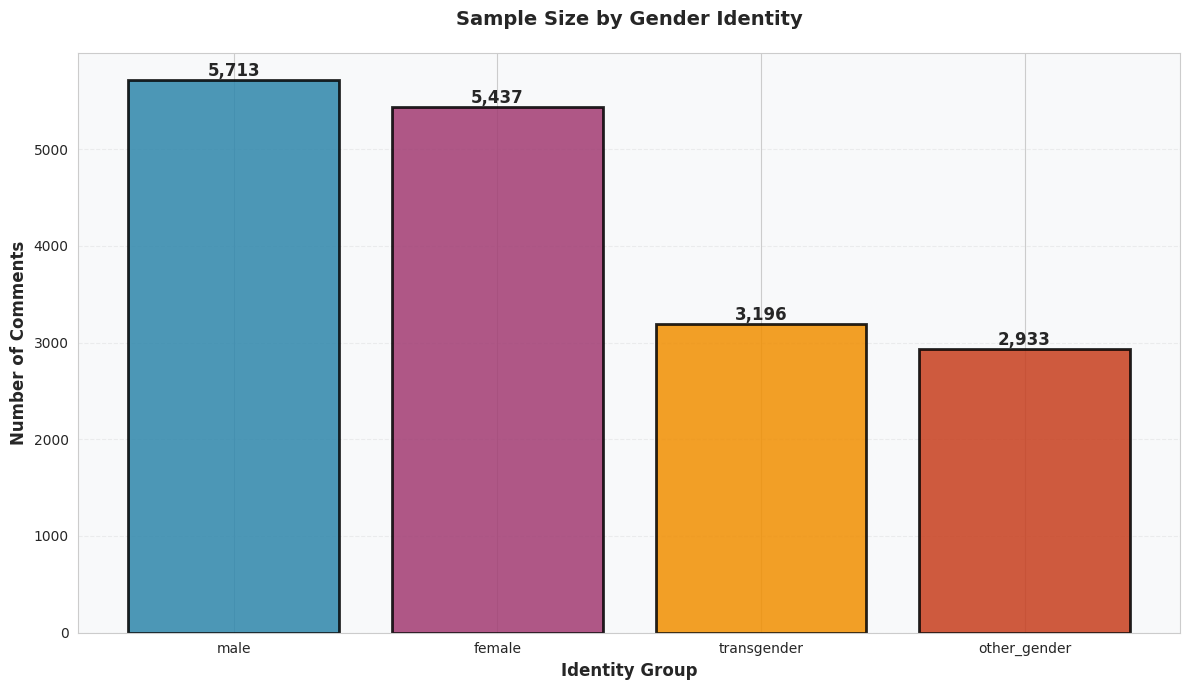

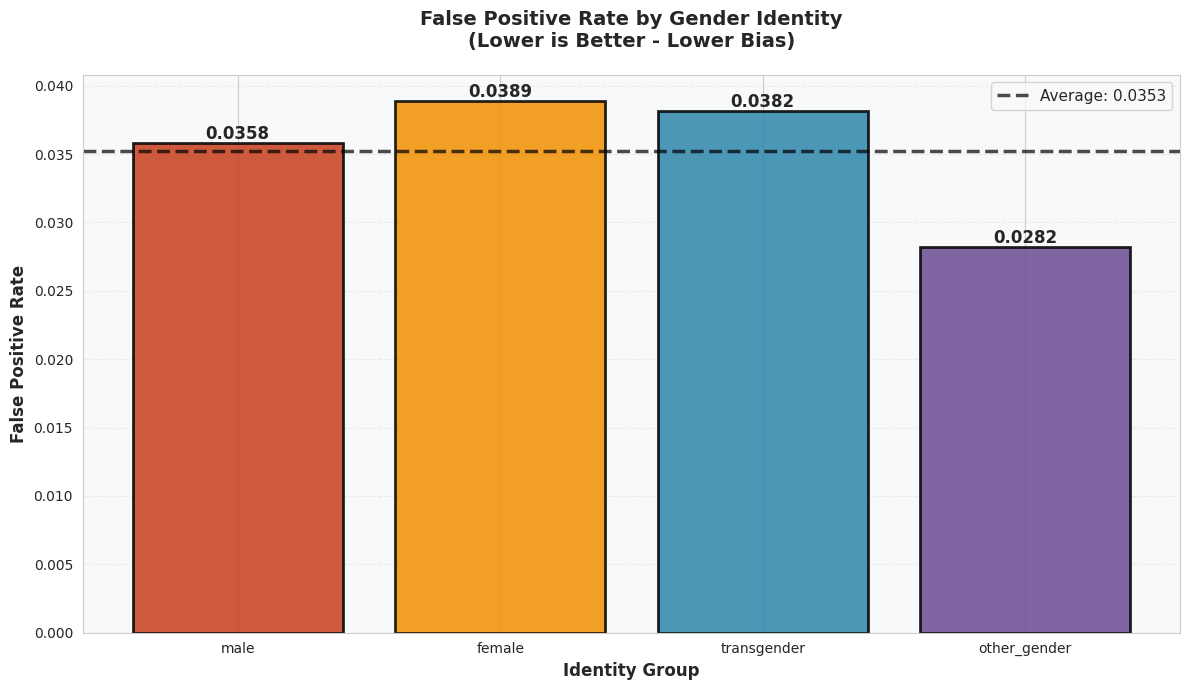

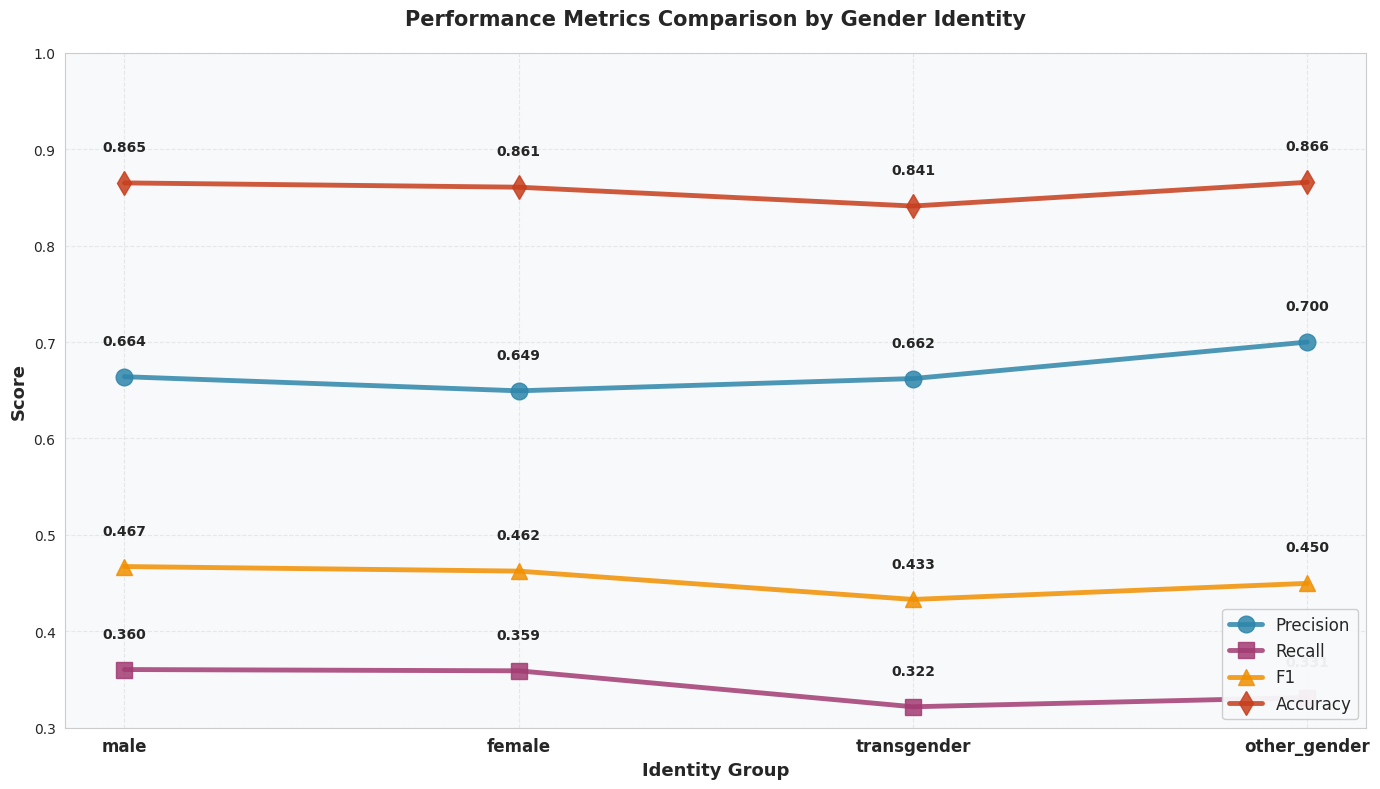


SUMMARY - GENDER DATASET

     Identity Count  Precision   Recall       F1  Accuracy  False_Positive_Rate
        male 5,713   0.664047 0.360341 0.467173  0.865045             0.035812
      female 5,437   0.649402 0.359031 0.462411  0.860585             0.038861
 transgender 3,196   0.662116 0.321725 0.433036  0.841051             0.038180
other_gender 2,933   0.700000 0.331276 0.449721  0.865667             0.028198

✓ Visualizations saved:
  - detoxify_gender_sample_size.png
  - detoxify_gender_fpr_by_identity.png
  - detoxify_gender_all_metrics.png
  - detoxify_gender_metrics_line.png
  - detoxify_gender_deviation_from_mean.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

bias_df = pd.read_csv(f'detoxify_{DATASET_TYPE}_metrics_by_identity.csv')
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'


# ==========================================
# 1) SAMPLE SIZE BAR CHART
# ==========================================

fig, ax = plt.subplots(figsize=(12, 7))
colors_sample = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
bars = ax.bar(bias_df['Identity'], bias_df['Count'], color=colors_sample, alpha=0.85, edgecolor='black', linewidth=2)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Number of Comments',fontweight='bold', fontsize=12)
ax.set_xlabel('Identity Group',fontweight='bold', fontsize=12)
ax.set_title(f'Sample Size by {DATASET_TYPE.capitalize()} Identity', fontweight='bold', fontsize=14, pad=20)
ax.grid(axis='y', alpha=0.3,linestyle='--')
plt.tight_layout()
plt.savefig(f'detoxify_{DATASET_TYPE}_sample_size.png', dpi=300, bbox_inches='tight')
plt.show()


# ==========================================
# 2) FALSE POSITIVE RATE BAR CHART
# ==========================================

#False positive rate by identity
fig, ax = plt.subplots(figsize=(12, 7))
colors_fpr = ['#C73E1D', '#F18F01', '#2E86AB', '#6A4C93']
bars = ax.bar(bias_df['Identity'], bias_df['False_Positive_Rate'], color=colors_fpr, alpha=0.85, edgecolor='black', linewidth=2)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

overall_fpr = bias_df['False_Positive_Rate'].mean()
ax.axhline(overall_fpr, color='black', linestyle='--', linewidth=2.5, label=f'Average: {overall_fpr:.4f}', alpha=0.7)

ax.set_ylabel('False Positive Rate', fontweight='bold', fontsize=12)
ax.set_xlabel('Identity Group', fontweight='bold', fontsize=12)
ax.set_title(f'False Positive Rate by {DATASET_TYPE.capitalize()} Identity\n(Lower is Better - Lower Bias)', fontweight='bold', fontsize=14, pad=20)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(f'detoxify_{DATASET_TYPE}_fpr_by_identity.png', dpi=300, bbox_inches='tight')
plt.show()


# ==========================================
# 3) LINE PLOT OF METRICS
# ==========================================

fig, ax = plt.subplots(figsize=(14, 8))
metrics_plot = ['Precision', 'Recall', 'F1', 'Accuracy']
colors_lines = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
markers = ['o', 's', '^', 'd']
x_pos = np.arange(len(bias_df))

for i, metric in enumerate(metrics_plot):
    ax.plot(x_pos, bias_df[metric], marker=markers[i], markersize=12, linewidth=3.5,
            label=metric, color=colors_lines[i], alpha=0.85)
    for j, val in enumerate(bias_df[metric]):
        ax.text(j, val + 0.03, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xticks(x_pos)
ax.set_xticklabels(bias_df['Identity'], fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontweight='bold', fontsize=13)
ax.set_xlabel('Identity Group', fontweight='bold', fontsize=13)
ax.set_title(f'Performance Metrics Comparison by {DATASET_TYPE.capitalize()} Identity', fontweight='bold', fontsize=15, pad=20)
ax.legend(fontsize=12, loc='lower right', framealpha=0.95)
ax.set_ylim(0.3, 1)
ax.grid(True, alpha=0.4, linestyle='--')
plt.tight_layout()
plt.savefig(f'detoxify_{DATASET_TYPE}_metrics_line.png', dpi=300, bbox_inches='tight')
plt.show()


# ==========================================
# 4) SUMMARY TABLE PRINT
# ==========================================

print("\n" + "="*80)
print(f"SUMMARY - {DATASET_TYPE.upper()} DATASET")
print("="*80)

summary_table = bias_df[['Identity', 'Count', 'Precision', 'Recall', 'F1', 'Accuracy', 'False_Positive_Rate']].copy()
summary_table['Count'] = summary_table['Count'].apply(lambda x: f'{int(x):,}')

print("\n", summary_table.to_string(index=False))

print(f"\n✓ Visualizations saved:")
print(f"  - detoxify_{DATASET_TYPE}_sample_size.png")
print(f"  - detoxify_{DATASET_TYPE}_fpr_by_identity.png")
print(f"  - detoxify_{DATASET_TYPE}_all_metrics.png")
print(f"  - detoxify_{DATASET_TYPE}_metrics_line.png")
print(f"  - detoxify_{DATASET_TYPE}_deviation_from_mean.png")